# RAFT: Generating data to fine-tune LLM for better QA

## Introduction
RAFT (Retrieval Augmented Fine-Tuning) is a technique for adapting LLMs to specific domains, like answering questions about your documents or APIs.


RAFT takes an input document from the user and creates a dataset using the document, consisting of synthetically generated { question, answer, documents } triplets. The dataset can then be used to fine-tune models for improved question-answering and retrieval.

- In this tutorial, you'll learn how to:

  - Install RAFT
  - Prepare your data in your domain.


### Why use RAFT?
- Improves accuracy
- Tailors LLMs to your data
- Simplifies fine-tuning

### RAFT generation flow

  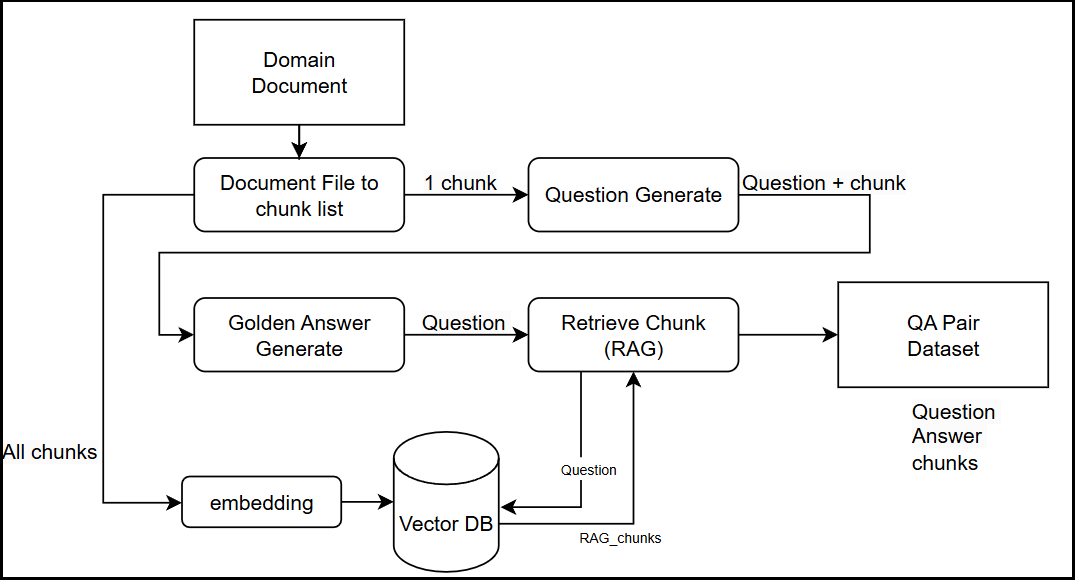


## Preliminary Settings
1. create directory "test_data" under the current folder (click the tab on the left with folder icon)
2. upload test data (Device Modeling MQA.pdf)
3. insert secret key for API call (click the tab on the left with key icon)
  
  name: AOAI_API_KEY
  
  value: ETRgTZYxpqtyjQeKxoEtWXugpFXDvglzOXZk21IGfGRQYfRpBYLjJQQJ99ALACfhMk5XJ3w3AAABACOGId7r
4. enable notebook accessibility

# Step1: Install necessary packages:

In [11]:
!pip install datasets==2.16.1
!pip install openai==1.10.0
!pip install PyPDF2==3.0.1
!pip install transformers==4.37.2
!pip install langchain_experimental
!pip install langchain_openai
!pip install python-dotenv==1.0.1
!pip install pyyaml==6.0.1
!pip install coloredlogs==15.0.1
!pip install mdc==1.2.1
!pip install pytest==8.1.2
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu118
!pip install faiss-cpu
!pip install peft==0.10.0

  Using cached openai-1.10.0-py3-none-any.whl.metadata (18 kB)
Using cached openai-1.10.0-py3-none-any.whl (225 kB)
  Attempting uninstall: openai
    Found existing installation: openai 1.65.1
    Uninstalling openai-1.65.1:
      Successfully uninstalled openai-1.65.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-openai 0.3.7 requires openai<2.0.0,>=1.58.1, but you have openai 1.10.0 which is incompatible.
  Using cached openai-1.65.1-py3-none-any.whl.metadata (27 kB)
Using cached openai-1.65.1-py3-none-any.whl (472 kB)
  Attempting uninstall: openai
    Found existing installation: openai 1.10.0
    Uninstalling openai-1.10.0:
      Successfully uninstalled openai-1.10.0
Looking in indexes: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: peft
    Found 

In [2]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
from tqdm import tqdm
from openai import OpenAI, OpenAIError

from tqdm import tqdm
import logging
from typing import Literal, Any, get_args
import argparse
from openai import OpenAI, BadRequestError
import datasets
from datasets import Dataset, concatenate_datasets
import pyarrow as pa
from transformers import AutoTokenizer
import json
import PyPDF2
import random
from langchain_experimental.text_splitter import SemanticChunker
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document

from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

import faiss
import numpy as np
from uuid import uuid4
from math import ceil

from pathlib import Path
from dotenv import load_dotenv

import uuid
import shutil
from threading import Thread, Event
from typing import List
import requests

In [3]:
DocType = Literal["pdf", "json", "txt"]
docTypes = list(get_args(DocType))

SystemPromptKey = Literal["gpt", "llama"]
systemPromptKeys = list(get_args(SystemPromptKey))

In [4]:
def get_doc_chunks(
    file_path: Path,
    doctype: DocType = "pdf",
    chunk_size: int = 512,
 ) -> list[str]:
    if doctype == "json":
        with open(file_path, 'r') as f:
            data = json.load(f)
        text = data["text"]
    elif doctype == "pdf":
        text = ""
        with open(file_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            num_pages = len(reader.pages)
            for page_num in range(num_pages):
                page = reader.pages[page_num]
                text += page.extract_text()
    elif doctype == "txt":
        with open(file_path, 'r') as file:
            data = file.read()
        text = str(data)
    else:
        raise TypeError("Document is not one of the accepted types: api, pdf, json, txt")

    num_chunks = ceil(len(text) / chunk_size)
    print(f"Splitting text into {num_chunks} chunks.")

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=int(chunk_size/8), length_function = len)
    chunks = text_splitter.create_documents([text])
    chunks = [chunk.page_content for chunk in chunks]
    return chunks

In [5]:
def get_chunks(
    data_path: Path,
    doctype: DocType = "pdf",
    chunk_size: int = 512,
    openai_key: str | None = None,
    model: OpenAIEmbeddings = None
) -> list[str]:
    """
    Takes in a `data_path` and `doctype`, retrieves the document, breaks it down into chunks of size
    `chunk_size`, and returns the chunks.
    """
    chunks = []



    chunks = []
    file_paths = [data_path]
    if data_path.is_dir():
        file_paths = list(data_path.rglob('**/*.' + doctype))

    futures = []
    with tqdm(total=len(file_paths), desc="Chunking", unit="file") as pbar:
        with ThreadPoolExecutor(max_workers=2) as executor:
            for file_path in file_paths:
                futures.append(executor.submit(get_doc_chunks, file_path, doctype, chunk_size))
            for future in as_completed(futures):
                doc_chunks = future.result()
                chunks.extend(doc_chunks)
                pbar.set_postfix({'chunks': len(chunks)})
                pbar.update(1)

    return chunks

# Step2: Generating Text Chunks from PDFs

1. Place your files (in PDF, JSON, or TXT format) in the /content/test_data folder.
2. If there is no '**test_data**' folder, please right-click on the left and select '**New Folder**' and name it '**test_data**'
  
  2.1 new folder

  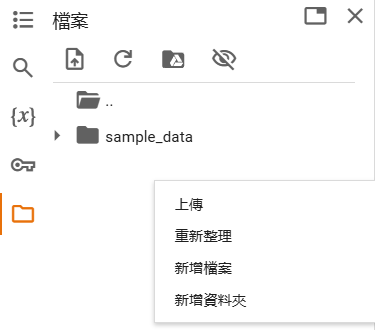
  
  2.2 rename folder

  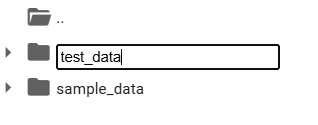

3. To generate text chunks from Documents, use the get_chunks function with these parameters:

  - datapath: Path to your PDFs, e.g., Path("./test_dataset").
  - doctype: Document type, set to "pdf".   There are "pdf", "json", "txt" options
  - CHUNK_SIZE: Size of each chunk, here it's 256.


In [6]:
datapath = Path("./test_data")
doctype = "pdf"
CHUNK_SIZE = 256

chunks = get_chunks(datapath, doctype, CHUNK_SIZE)

Chunking: 100%|██████████| 1/1 [00:00<00:00,  4.38file/s, chunks=44]

Splitting text into 34 chunks.


**chunks** is a list where each item is a string
```
[
  "Chunk 1 content (string)",
  "Chunk 2 content (string)",
  "Chunk 3 content (string)"
]
```

## build_qa_messages (generate question)
This function generates a sequence of prompts to provide context and instructions to the language model, either GPT or LLaMA, guiding them to create synthetic questions from a given text chunk.

1. System Prompt for GPT:

  - This prompt introduces GPT as a synthetic question-answer pair generator.
  - The instructions emphasize generating example questions based on the context that can be answered with a few words.
  - The instructions explicitly mention that questions should directly arise from the given context and should match the language of the context.
  - There is more focus on the brevity and language conformity of the questions.

2. System Prompt for LLaMA:

  - This prompt introduces LLaMA as a synthetic question generator, focusing on generating questions from the context.
  - Unlike GPT's more general instruction, it specifies that questions should be listed one per line.
  - It provides a detailed explanation, including example scenarios and questions, making it very explicit.
  - Emphasizes succinctness and matching the language of the context similar to GPT, but with more structured instructions.

## prompt_templates (generate answer)
These templates are used to create a structured prompt when answering questions based on context provided:

1. Prompt Template for GPT:

  - The introduction outlines the task of answering questions using context.
  - It requires step-by-step reasoning, explaining why certain context parts are useful.
  - Instructs GPT to quote parts of the context with specific markers (##begin_quote## and ##end_quote##) for clarity on the exact text used.
  - It emphasizes ending with a succinct answer labeled with "<ANSWER>:" and ensuring language matches with the question.

2. Prompt Template for LLaMA:

  - Very similar to GPT, but offers more detailed guidance.
  - Requires step-by-step reasoning and quoting relevant context.
  - Provides an example question and answer format, illustrating how the answer should be constructed.
  - Instructions emphasize clarity and the explicit inclusion of meaningful context through quoting.
  - Also requires a tagged final answer ("<ANSWER>:") in line with the language of the question.

In [7]:
build_qa_messages = {
    "gpt": lambda chunk, x : [
            {"role": "system", "content": """You are a synthetic question-answer pair generator. Given a chunk of context about
             some topic(s), generate %s example questions a user could ask and would be answered using information from the chunk.
             For example, if the given context was a Wikipedia paragraph about the United States, an example question could be
             'How many states are in the United States?'""" % (x)},
            {"role": "system", "content": "The questions should be able to be answered in a few words or less. Include only the questions in your response. The language of the generated question should match the language of the given context."},
            {"role": "user", "content": str(chunk)}
        ],
    "llama": lambda chunk, x : [
            {"role": "system", "content":
                """You are a synthetic question generator.

                Instructions:
                - Given a chunk of context about some topic(s), generate %s example questions a user could ask
                - Questions should be answerable using only information from the chunk.
                - Generate one question per line
                - Generate only questions
                - Questions should be succinct
                - The language of the generated question should match the language of the given context.

                Here are some samples:
                Context: A Wikipedia paragraph about the United States,
                Question: How many states are in the United States?

                Context: A Wikipedia paragraph about vampire bats,
                Question: What are the different species of vampire bats?
                """ % (x)},
            {"role": "system", "content": "The questions should be able to be answered in a few words or less. Include only the questions in your response."},
            {"role": "user", "content": str(chunk)}
        ]
}

prompt_templates = {
    "gpt": """
        Question: {question}\nContext: {context}\n
        Answer this question using the information given in the context above. Here is things to pay attention to:
        - First provide step-by-step reasoning on how to answer the question.
        - In the reasoning, if you need to copy paste some sentences from the context, include them in ##begin_quote## and ##end_quote##. This would mean that things outside of ##begin_quote## and ##end_quote## are not directly copy paste from the context.
        - End your response with final answer in the form <ANSWER>: $answer, the answer should be succinct.
        - The language of the generated answer should match the language of the given question.
        You MUST begin your final answer with the tag "<ANSWER>:".
    """,
    "llama": """
        Question: {question}
        Context: {context}

        Answer this question using the information given in the context above.

        Instructions:
        - Provide step-by-step reasoning on how to answer the question.
        - Explain which parts of the context are meaningful and why.
        - Copy paste the relevant sentences from the context in ##begin_quote## and ##end_quote##.
        - Provide a summary of how you reached your answer.
        - End your response with the final answer in the form <ANSWER>: $answer, the answer should be succinct.
        - You MUST begin your final answer with the tag "<ANSWER>:".
        - The language of the generated answer should match the language of the given question.

        Here are some samples:

        Example question: What movement did the arrest of Jack Weinberg in Sproul Plaza give rise to?
        Example answer: To answer the question, we need to identify the movement that was sparked by the arrest of Jack Weinberg in Sproul Plaza.
        The context provided gives us the necessary information to determine this.
        First, we look for the part of the context that directly mentions Jack Weinberg's arrest.
        We find it in the sentence: ##begin_quote##The arrest in Sproul Plaza of Jack Weinberg, a recent Berkeley alumnus and chair of Campus CORE,
        prompted a series of student-led acts of formal remonstrance and civil disobedience that ultimately gave rise to the Free Speech Movement##end_quote##.
        From this sentence, we understand that the arrest of Jack Weinberg led to student-led acts which then gave rise to a specific movement.
        The name of the movement is explicitly mentioned in the same sentence as the "Free Speech Movement."
        Therefore, based on the context provided, we can conclude that the arrest of Jack Weinberg in Sproul Plaza gave rise to the Free Speech Movement.
        <ANSWER>: Free Speech Movement
    """
    }

def strip_str(s: str) -> str:
    """
    Helper function for helping format strings returned by GPT-4.
    """
    l, r = 0, len(s)-1
    beg_found = False
    for i in range(len(s)):
        if s[i].isalpha():
            if not beg_found:
                l = i
                beg_found = True
            else:
                r = i
    r += 2
    return s[l:min(r, len(s))]

def generate_instructions_gen(chat_completer, chunk: Any, x: int = 5, model: str = None, prompt_key : str = "gpt") -> list[str]:
    """
    Generates `x` questions / use cases for `chunk`. Used when the input document is of general types
    `pdf`, `json`, or `txt`.
    """
    max_tokens = min(25 * x, 512)
    messages = build_qa_messages[prompt_key](chunk, x)

    if isinstance(chat_completer, list):
      GPT4V_KEY = chat_completer[1]
      GPT4V_ENDPOINT = chat_completer[2]
      headers = {
          "Content-Type": "application/json",
          "api-key": GPT4V_KEY,
      }

      payload = {
          "messages": messages,
          "temperature": 0.0,
          "top_p": 0.0,
          "max_tokens": 800
      }
      response = requests.post(GPT4V_ENDPOINT, headers=headers, json=payload)
      content = response.json()['choices'][0]['message']['content']

    else:
      try:
          response = chat_completer(
              model=model,
              messages=messages,
              max_tokens=max_tokens, # 25 tokens per question
          )
      except BadRequestError as e:
          if e.code == "content_filter":
              print(f"Got content filter error, skipping chunk: {e.message}")
              return []
          raise e

      content = response.choices[0].message.content

    # after LLM Calling

    queries = content.split('\n') if content else []
    #queries = [strip_str(q) for q in queries]
    queries = [q for q in queries if any(c.isalpha() for c in q)]

    return queries

In [8]:
def generate_question_cot_answer(
        chat_completer,
        chunks: list[str],
        chunk: str,
        chunk_id,
        question,
        doctype: DocType = "api",
        num_retrieve: int = 3,
        p: float = 0.8,
        model: str = None,
        prompt_key: str = "gpt",
        vector_store: FAISS = None
        ):
    datapt = {
            "id": None,
            "type": None,
            "question": None,
            "context": None,
            "oracle_context": None,
            "cot_answer": None
        }

    datapt["id"] = str(uuid.uuid4())
    datapt["type"] = "api call" if doctype == "api" else "general"
    datapt["question"] = question

    # # add num_retrieve distractor docs
    docs = [chunk]
    # indices = list(range(0, len(chunks)))
    # indices.remove(chunk_id)
    # for j in random.sample(indices, num_retrieve):
    #     docs.append(chunks[j])
    # decides whether to add oracle document
    # oracle = random.uniform(0, 1) < p
    # if not oracle:
    #     docs[0] = chunks[random.sample(indices, 1)[0]]
    # random.shuffle(docs)


    # query_embedding = np.array(embeddings_model.embed_query(question)).astype('float32').reshape(1, -1)
    # distances, indices = faiss_index.search(query_embedding, num_retrieve)
    chunk_score_list = vector_store.similarity_search_with_score(question, k=num_retrieve)

    rag_docs = []
    for search_chunk in chunk_score_list:
        rag_docs.append(search_chunk[0].page_content)

    # d["title"].append(["placeholder_title"]*(num_retrieve+1))
    # d["sentences"].append(docs)
    datapt["context"] = rag_docs
    datapt["oracle_context"] = chunk

    docs.extend(rag_docs)

    # add answer to q
    datapt["cot_answer"] = generate_label(chat_completer, question, chunk, doctype, model=model, prompt_key=prompt_key)

    # construct model instruction
    context = ""
    for doc in docs:
        context += "<DOCUMENT>" + str(doc) + "</DOCUMENT>\n"
    context += question
    datapt["instruction"] = context
    return datapt

def encode_question_gen(question: str, chunk: Any, prompt_key : str = "gpt") -> list[str]:
    """
    Encode multiple prompt instructions into a single string for the general case (`pdf`, `json`, or `txt`).
    """

    prompts = []

    prompt = prompt_templates[prompt_key].format(question=question, context=str(chunk))
    prompts.append({"role": "system", "content": "You are a helpful question answerer who can provide an answer given a question and relevant context."})
    prompts.append({"role": "user", "content": prompt})
    return prompts

def generate_label(chat_completer, question: str, context: Any, doctype: DocType = "pdf", model: str = None, prompt_key : str = "gpt") -> str | None:
    """
    Generates the label / answer to `question` using `context` and GPT-4.
    """
    question = encode_question_gen(question, context, prompt_key)


    if isinstance(chat_completer, list):
      GPT4V_KEY = chat_completer[1]
      GPT4V_ENDPOINT = chat_completer[2]
      headers = {
          "Content-Type": "application/json",
          "api-key": GPT4V_KEY,
      }

      payload = {
          "messages": question,
          "temperature": 0.0,
          "top_p": 0.0,
          "max_tokens": 800
          }
      response = requests.post(GPT4V_ENDPOINT, headers=headers, json=payload)
      print('keys in response: ', response.json().keys())
      try:
        response = response.json()['choices'][0]['message']['content']
      except:
        print('error in response: ', response.json()['error'])
      return response


    response = chat_completer(
        model=model,
        messages=question,
        n=1,
        temperature=0,
        max_tokens=10240,
    )
    response = response.choices[0].message.content
    return response

In [9]:


def stage_generate(chat_completer, chunks, num_questions, max_workers, doctype, completion_model, system_prompt_key, num_retrieve, embeddings_model):
    """
    Given a chunk, create {Q, A, D} triplets and add them to the dataset.
    """


    num_chunks = len(chunks)

    # Tracking when the process is stopping, so we can stop the generation process early
    # Initial value is False
    is_stopping = Event()


    def generate_chunk_instructions_ds(chunk: str, chunk_id: int, doctype: str, *args, **kwargs):
        """
        Generates a dataset of instructions for a given chunk.
        """
        questions = generate_instructions_gen(chunk=chunk, *args, **kwargs)
        # chunk_question_pairs = [{"chunk": chunk, "chunk_id": chunk_id, "question": question} for question in questions]
        chunk_question_pairs = []
        for question in questions:
            pair = {
                "chunk": chunk,
                "chunk_id": chunk_id,
                "question": question
            }
            chunk_question_pairs.append(pair)
        questions_ds = Dataset.from_list(chunk_question_pairs)
        return questions_ds


    def generate_question_cot_answers(questions_ds, chunk_id: int, chunk: str, *args, **kwargs):
        def process_example(chunk, question):
            try:
                cot_answer = generate_question_cot_answer(chunk=chunk, chunk_id=chunk_id, chunks=chunks, question=question, *args, **kwargs)
            except BadRequestError as e:
                if e.code == "content_filter":
                    print(f"Got content filter error, skipping question '{question}': {e.message}")
                    return None
                raise e

            return cot_answer

        # 初始化结果列表
        results = []

        # 检查 questions_ds 是否包含数据
        if len(questions_ds) > 0:
            # 遍历 questions_ds 中的 chunk 和 question
            for chunk, question in zip(questions_ds['chunk'], questions_ds['question']):
                # 处理每个示例并将结果添加到结果列表中
                result = process_example(chunk, question)
                results.append(result)

        results = [r for r in results if r is not None]
        table = pa.Table.from_pylist(results)
        ds = Dataset(table)
        return ds

    def process_chunk(chunk, index, vector_store):

        questions_ds = generate_chunk_instructions_ds(chunk=chunk, chunk_id=index, chat_completer=chat_completer, x=num_questions, model=completion_model, doctype=doctype, prompt_key=system_prompt_key)

        answers_ds = generate_question_cot_answers(questions_ds=questions_ds, chunk=chunk, chunk_id=index, chat_completer=chat_completer, model=completion_model, doctype=doctype, prompt_key=system_prompt_key, num_retrieve=num_retrieve, vector_store=vector_store)
        return answers_ds


    # embeddings = embeddings_model.embed_documents(chunks)
    # embeddings_array = np.array(embeddings).astype('float32')

    # dimension = embeddings_array.shape[1]
    # faiss_index = faiss.IndexFlatL2(dimension)
    # faiss_index.add(embeddings_array)


    index = faiss.IndexFlatL2(len(embeddings_model.embed_query("hello world")))
    vector_store = FAISS(
        embedding_function=embeddings_model,
        index=index,
        docstore=InMemoryDocstore(),
        index_to_docstore_id={},
    )

    documents = [Document(page_content=chunk, metadata={"source": f"chunk-{i}"}) for i, chunk in enumerate(chunks)]
    uuids = [str(uuid4()) for _ in range(len(documents))]

    vector_store.add_documents(documents=documents, ids=uuids)

    answers_ds_list=[]
    for index, chunk in enumerate(tqdm(chunks, desc="Generating QA")):
      answers_ds = process_chunk(chunk, index, vector_store)
      answers_ds_list.append(answers_ds)


    return answers_ds_list

# Step3: Use OpenAI's model to produce question and answer sets

1. Set the data generation parameters.
  - **num_questions**: Number of questions to generate per chunk
  - **NUM_RETRIEVE_DOCS**: Set the number of chunks to retrieve for each question
  - **completion_model**: Model used to generate questions and answers
  - **system_prompt_key**: Select the key of prompt templete (if it is OpenAI model, it is "gpt")
  - **OPENAI_API_KEY**: The api key generated by OpenAI
  - embedding_model_name: OpenAI embedding model name

2. Click "secret" in the options bar on the left

  2.1 select new secret

  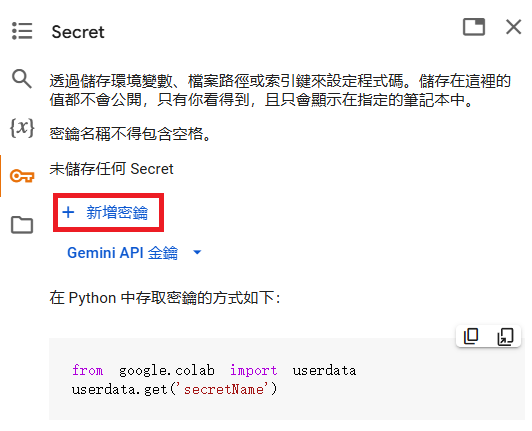

  2.2 Set the name to **"OPENAI_API_KEY"** and set the value to your OpenAI Api-Key

  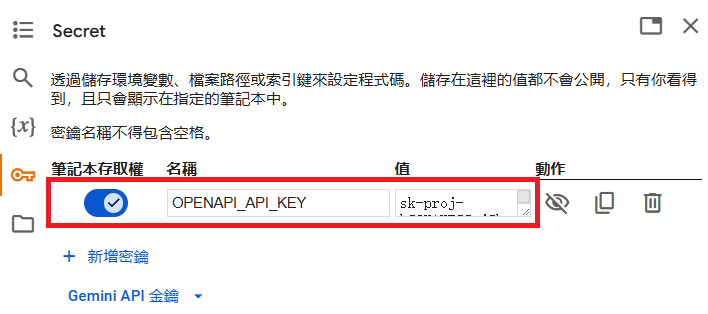



3. Generate a question and answer set using the "**stage_generate()**" function, which uses the "generate_instructions_gen" and "generate_question_cot_answer" functions to generate questions and answers.

#  Use **AOAI** model to produce question and answer sets

In order to avoid connection issues, we already set up the AOAI server in Headquarters！ We can directly send requests to end-point and resolve the returned content.

In [12]:
# Number of questions to generate per chunk
num_questions = 1
NUM_RETRIEVE_DOCS = 3

completion_model = "gpt-4o"
system_prompt_key = "gpt"

from google.colab import userdata
AOAI_API_KEY = userdata.get('AOAI_API_KEY')


# embedding model for RAG
embed_model_kwargs = {'device': 'cpu', "trust_remote_code": "True"}
encode_kwargs = {'normalize_embeddings': True}
embedding_model_name = "intfloat/multilingual-e5-large"
hf_embedding = HuggingFaceEmbeddings(model_name=embedding_model_name,model_kwargs=embed_model_kwargs,encode_kwargs=encode_kwargs)

# create client
# base_url = "https://phisonaoaidveswc.openai.azure.com/openai/deployments/gpt4o/chat/completions?api-version=2024-10-01-preview"
# base_url = "https://phisonaoaidveswc.openai.azure.com/openai/realtime?api-version=2024-10-01-preview&deployment=gpt-4o-realtime-preview"
base_url = "https://phisonaoaidveswc.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-08-01-preview"
chat_completer = ["AOAI", AOAI_API_KEY, base_url]
max_workers = 5
test_chunk_size = 5

test_chunks = chunks[0:test_chunk_size]
for idx, chunk in enumerate(test_chunks):
    print(f'chunk index: {idx} \nchunk:{chunk}\n')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/160k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

chunk index: 0 
chunk:See discussions, st ats, and author pr ofiles f or this public ation at : https://www .researchgate.ne t/public ation/221248752
Social Conformity and Its Convergence for Reinforcement Learning
Conf erence Paper  · Sept ember 2010

chunk index: 1 
chunk:DOI: 10.1007/978-3-642-16178-0_15  · Sour ce: DBLP
CITATIONS
2READS
68
3 author s, including:
Some o f the author s of this public ation ar e also w orking on these r elat ed pr ojects:
EUMAS 2016  View pr oject
Social Emotional R obot  View pr oject

chunk index: 2 
chunk:Juan Gar cía-P ardo
ETH Z urich
11 PUBLICA TIONS    47 CITATIONS    
SEE PROFILE
José Soler
Univ ersitat P olitècnic a de V alència
21 PUBLICA TIONS    197 CITATIONS    
SEE PROFILE

chunk index: 3 
chunk:SEE PROFILE
All c ontent f ollo wing this p age was uplo aded b y Carlos Carr ascosa on 16 May 2014.

chunk index: 4 
chunk:The user has r equest ed enhanc ement of the do wnlo aded file.Social Conformity and its Convergence for Reinforcement Lea

#  Start producing question and answer sets

In [13]:
cot_answers_ds = stage_generate(
    chat_completer,
    test_chunks,
    num_questions,
    max_workers,
    doctype,
    completion_model,
    system_prompt_key,
    num_retrieve=NUM_RETRIEVE_DOCS,
    embeddings_model=hf_embedding
)

Generating QA:  20%|██        | 1/5 [00:13<00:52, 13.13s/it]

keys in response:  dict_keys(['choices', 'created', 'id', 'model', 'object', 'prompt_filter_results', 'system_fingerprint', 'usage'])


Generating QA:  40%|████      | 2/5 [00:23<00:34, 11.50s/it]

keys in response:  dict_keys(['choices', 'created', 'id', 'model', 'object', 'prompt_filter_results', 'system_fingerprint', 'usage'])


Generating QA:  60%|██████    | 3/5 [00:29<00:17,  8.95s/it]

keys in response:  dict_keys(['choices', 'created', 'id', 'model', 'object', 'prompt_filter_results', 'system_fingerprint', 'usage'])


Generating QA:  80%|████████  | 4/5 [00:33<00:07,  7.23s/it]

keys in response:  dict_keys(['choices', 'created', 'id', 'model', 'object', 'prompt_filter_results', 'system_fingerprint', 'usage'])


Generating QA: 100%|██████████| 5/5 [00:59<00:00, 11.94s/it]

keys in response:  dict_keys(['choices', 'created', 'id', 'model', 'object', 'prompt_filter_results', 'system_fingerprint', 'usage'])


# Step4: Save QA Pair Dataset to json

In [14]:
cot_answers_list = []
for dataset in cot_answers_ds:
    row_dict = {feature: dataset[feature][0] for feature in dataset.column_names}
    cot_answers_list.append(row_dict)

# save to json
with open("qa_list.json", "w", encoding="utf-8") as fp:
    json.dump(cot_answers_list, fp, indent=4, ensure_ascii = False)


print(cot_answers_ds)

[Dataset({
    features: ['id', 'type', 'question', 'context', 'oracle_context', 'cot_answer', 'instruction'],
    num_rows: 1
}), Dataset({
    features: ['id', 'type', 'question', 'context', 'oracle_context', 'cot_answer', 'instruction'],
    num_rows: 1
}), Dataset({
    features: ['id', 'type', 'question', 'context', 'oracle_context', 'cot_answer', 'instruction'],
    num_rows: 1
}), Dataset({
    features: ['id', 'type', 'question', 'context', 'oracle_context', 'cot_answer', 'instruction'],
    num_rows: 1
}), Dataset({
    features: ['id', 'type', 'question', 'context', 'oracle_context', 'cot_answer', 'instruction'],
    num_rows: 1
})]


## Things you can try
1. Upload different files (from internet/from your own device).
2. Try different parameters (doctype, chunk_size, NUM_RETRIEVE_DOCS, test_chunk_size, System Prompt, Prompt template).